In [ ]:
!jupyter nbconvert soutenance.ipynb --to slides --post serve 

In [13]:
import numpy as np
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
import ipywidgets as widgets
from IPython.display import display

# difficult relative import
import sys
import os
sys.path.append(os.path.abspath('..'))
import codebase
from codebase.sparse_regression import *
from codebase.utils import *

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
ds = CountryDataset()

C:\Users\kipr\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [15]:
py_odes = loadmat('C:/Users/kipr/Documents/GitHub/files/internship/data/py_odes.mat')
cubic_oscillator = py_odes['cubic_oscillator']
t_ode = py_odes['t'][0]

def show_trajectory(data, weights):
    guess = integrate(weights, [0.5], 
                      np.arange(0, len(data)), 
                      derivative=derivative)

    guess = np.clip(guess, a_min=-1, a_max=2*max(data))

    plt.figure(dpi=100)
    plt.plot(data, 'k.', label='real')
    plt.plot(guess[:, 0], label='predicted') # problem
    plt.title(country)
    plt.legend()
    plt.show()


In [16]:
total_population = 1e2
t = np.arange(200)
initial_value = np.array([total_population*0.99, total_population*0.01, 0])

def integrate_sir(r0):
    def func(t, x, gamma=0.065, total_pop=total_population):
        [s, i, r] = x
        isn = gamma*r0(t)*s*i/total_pop
        return np.array([-isn, isn - gamma*i, gamma*i])
    res = solve_ivp(func, (t[0], t[-1]), initial_value, t_eval=t)

    f, ax = plt.subplots(dpi=130)
    
    ax.plot(res.y[0], label='S', linewidth=3)
    ax.plot(res.y[1], label='I', linewidth=3)
    ax.plot(res.y[2], label='R', linewidth=3)

    ax1 = ax.twinx()
    
    ax.set_ylabel('% of population')
    ax1.set_ylabel('R0 value', color='r')
    ax.set_xlabel('days')

    ax1.plot(np.vectorize(r0)(t), 'r--', label='r0')
    ax1.tick_params(axis='y', labelcolor='r')
    ax.legend()
    
def constant_r0(t):
    return 2

def piece_r0(t):
    if t < 10:
        return 2.5
    elif t < 55:
        return 1.
    elif t < 90:
        return 0.8
    elif t < 130:
        return 1.1
    else:
        return 2.

def exp_r0(t):
    return min(3., 20*np.exp(-t*0.1))  + np.random.randn()*0.2

<center>
    <h1> Data-driven COVID-19 modeling </h1>
</center>
<center>
<img src="image.png" width="400"></img>
</center>
<center>
Cyprien Neverov<small><sup>1</sup></small>
    </center>
<center>
August 28<sup>th</sup>, 2020
</center>

---
<small>
<sup>1</sup>
Student at IMT Mines Ales and intern at FAU Erlangen-Nurnberg under the supervision of Prof. Enrique Zuazua.
</small>

## Table of Contents

1. Data-driven system identification
2. Modeling COVID-19
3. Conclusion



## 1. Data-driven system identification

Identifying the dynamics from data is becoming a key challenge because:
 - Data acquisition is getting cheaper
 - Problems are getting more complex
 - Computational power is cheaper




### Sparse identification of nonlinear dynamical systems

Approach proposed by S. Brunton in [1]. 

- Uses sparse regression
- Relies on a set of candidate functions

Expresses the dynamics as a function $f$ which is a linear combination of the candidate functions:

$$\frac{dx}{dt}(t) = f(x(t))$$

where $x$ is the state of the system.

#### 1. Make two matrices 
Let's say that we have observed the system at $t_1, t_2, ..., t_m$ and either observed or numerically computed its time derivative at those time points, then we can construct the two following matrices:

$$\dot{X} = 
\begin{bmatrix}
\frac{dx}{dt}(t_1) \\
\frac{dx}{dt}(t_2) \\
\vdots \\
\frac{dx}{dt}(t_m)
\end{bmatrix}
\text{ and }
X = 
\begin{bmatrix}
x(t_1) \\
x(t_2) \\
\vdots \\
x(t_m)
\end{bmatrix}
$$


#### 2. Augment the state matrix
And then we can augment the $X$ matrix with the candidate functions $f_1, f_2, \dots, f_p$ this will yield $\theta(X)$:
$$\theta(X) = 
\begin{bmatrix}
f_1(x(t_1)) & f_2(x(t_1)) & \cdots & f_p(x(t_1))\\
f_1(x(t_2)) & f_2(x(t_2)) & \cdots & f_p(x(t_2))\\
\vdots & \vdots  & \ddots & \vdots\\
f_1(x(t_m)) & f_2(x(t_m)) & \cdots & f_p(x(t_m))\\
\end{bmatrix}
$$



#### 3. Solve the linear least squares

Now we want to find a matrix $\xi$ that is a solution to:

$$\dot{X} = \theta(X)\xi$$

in the least squares sense. The sparsity is achieved by running the optimization several times and gradually zeroing out the values that are under a cut-off value.

#### Discretized formulation

This algorithm also works in an iterative manner, when instead of $\dot{X}$ we have $X_2$:

$$
X_2 = 
\begin{bmatrix}
x(t_2) \\
x(t_3) \\
\vdots \\
x(t_m)
\end{bmatrix}
\text{ and }
X = 
\begin{bmatrix}
x(t_1) \\
x(t_2) \\
\vdots \\
x(t_{m-1})
\end{bmatrix}
$$

and then we seek to solve $X_2 = \theta(X)\xi$


### Simple example

Oscillator with a cubic nonlinearity:

\begin{align}
    \dot{x} & = -0.1x^3 + 2y^3 \\
    \dot{y} & = -2x^3 -0.1y^3 
\end{align}

From now on we will consider only polynomial terms of the variables as candidate functions: $1, x, y, x^2, xy, y^2, x^3, \dots, y^p$.


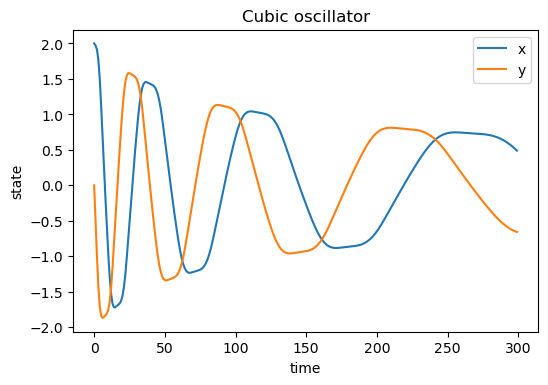

In [15]:
plt.figure(dpi=100)
plt.plot(cubic_oscillator[:, 0], label='x')
plt.plot(cubic_oscillator[:, 1], label='y')
plt.legend()
plt.xlabel('time')
plt.ylabel('state')
plt.title('Cubic oscillator')
plt.show()

### Simple example

In [27]:
X_dot, X = make_targets(cubic_oscillator, derivative=(derivative:=False))
  
theta_X, _ = make_polynomials(X, max_degree=3)

weights, _ = sparse_regression(theta_X, X_dot, cutoff=1e-3)
if derivative: weights /= t_ode[1]

show_weights(weights, derivative=derivative)

| function   |   $x_{k+1}$ |   $y_{k+1}$ |
|:-----------|------------:|------------:|
| $1$        |  0          |  0          |
| $ x$       |  1.00577    | -0.0013371  |
| $ y$       |  0          |  1.00572    |
| $ x^2$     |  0          |  0          |
| $ x y$     |  0          |  0          |
| $ y^2$     |  0          |  0          |
| $ x^3$     | -0.00816922 | -0.0645619  |
| $ x^2 y$   |  0          | -0.00932543 |
| $ x y^2$   | -0.00826491 |  0          |
| $ y^3$     |  0.0654499  | -0.00740647 |

## 2.  Modeling COVID-19

The trajectories of cumulative cases:

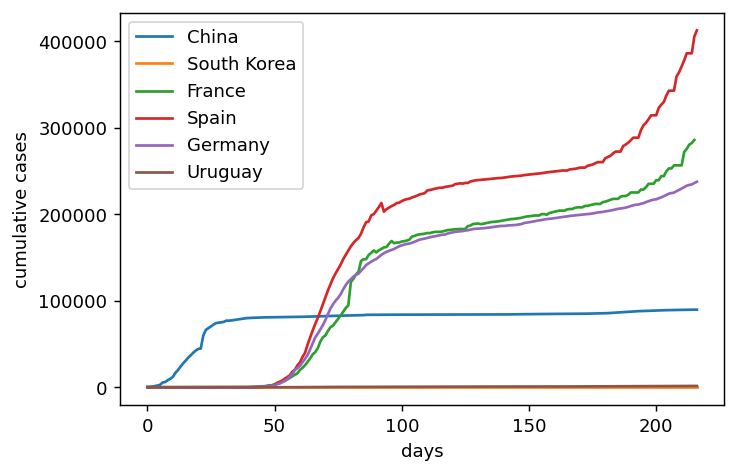

In [15]:
countries_to_display = ['China', 'South Korea', 'France', 'Spain', 'Germany', 'Uruguay']

plt.figure(dpi=130)
for country in countries_to_display:
    values = ds.cumulative(country)
    plt.plot(values, label=country)
plt.legend()
plt.xlabel('days')
plt.ylabel('cumulative cases')
plt.show()

### Single country trajectory

| function   |    $\dot{x}$ |
|:-----------|-------------:|
| $1$        | -0.000900268 |
| $ x$       |  0.372269    |
| $ x^2$     | -1.44715     |
| $ x^3$     |  2.3851      |
| $ x^4$     | -1.59452     |
| $ x^5$     |  0.36289     |

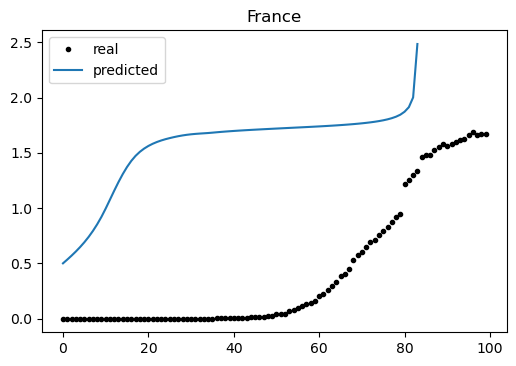

In [31]:
country = 'France'
data = ds.cumulative(country, rescaling=100000)[:100]
X_dot, X = make_targets(data[..., np.newaxis], derivative=(derivative:=True))
theta_X, _ = make_polynomials(X, max_degree=5)
weights, _ = sparse_regression(theta_X, X_dot, cutoff=1e-15)
show_weights(weights, derivative=derivative)
show_trajectory(data, weights)

### Observations

- A single trajectory can be described by only two or three parameters.
- The algorithm is not robust.
- We did not have the complete evolutions for most of the countries at the time of writing.

How can we use the information from countries that are more advanced into the epidemic to make predictions for countries at a more early stage ?

### Multi-country model

What if the evolution of the number of cases in several countries could be governed by a single formula?

This would require additional information:
- Information about the countries, the cultures;
- Information about the measures taken by the governments to tackle the spread of the disease.

We would like to find a function $f$ such that for any country $c$, at any day $t$, we have:

$$x_{t+1, c} = f(x_{t, c}, i_{t, c})$$

Where $i$ is this additional information.


### SINDy vs ARIMA

[ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) seems to be the preferred tool of statisticians to make COVID forecasting: [6, 7]. We compared the performance of our techniques to an ARIMA model for forecasting purposes:

<center><img src='Germany_forecast.png' width="1200"/></center>

### SINDy vs ARIMA

But it doesn't always work as expected.

<center><img src='Guinea_forecast.png' width="1200"/></center>

### SINDy vs ARIMA

| Percentage of best guesses | Error on 1 week forecast horizon  | Error on 2 weeks forecast horizon   |
|---|---|---|
| <img src='forecasting.png' width="600"/> | <img src='one_week.png' width="600"/>  | <img src='two_weeks.png' width="600"/>  |


### Other approaches/experiments

- [Rational basis functions](https://kipre.github.io/files/internship/reports/non-linear/nonlinear.html)
- [Time dependent dynamics](https://kipre.github.io/files/internship/reports/covid_time/index.html) 
- [Control measures](https://kipre.github.io/files/internship/reports/covid_control/report.html)
- N-Beats and NNs
- SIR fitting and recovering
- More precedent states ($x_{n-1}$, $x_{n-2}$) - autoregression.

## Conclusion


- System identification is challenging.
- In simple settings the SINDy algorithm learns well.
- In complex situations not so much.
- It was quite early to work on data-driven approaches.
- It is really sensitive to small hyperparameters changes.
- Sensitive to small data changes.
- Easily overfits.
- Random events had a big impact on the evolutions.



### Other tasks

- [`net2mat`](https://github.com/Kipre/net2mat) - a small program to transform GASLIB `.net` files to a MATLAB `.mat`. Written in C++.
- [System identification as a service](https://github.com/Kipre/files/tree/master/internship/siaas) - using the implemented algorithms to deploy a service through a REST API for identifying systems from data.

## References


[1] Brunton, Steven L., Joshua L. Proctor, and J. Nathan Kutz. 2016. “Discovering Governing Equations from Data by Sparse Identification of Nonlinear Dynamical Systems.” <em>Proceedings of the National Academy of Sciences</em> 113 (15): 3932–7. <a href="https://doi.org/10.1073/pnas.1517384113">https://doi.org/10.1073/pnas.1517384113</a>.


[2] Hale, Thomas, Sam Webster, Anna Petherick, Toby Phillips, and Beatriz Kira. 2020. “Oxford COVID-19 Government Response Tracker.” <em>Blavatnik School of Government</em>. <a href="https://github.com/OxCGRT/covid-policy-tracker/">https://github.com/OxCGRT/covid-policy-tracker/</a>.

[3] “Understanding the Coronavirus (COVID-19) Pandemic Through Data. World Bank.” n.d. <a href="http://datatopics.worldbank.org/universal-health-coverage/covid19/">http://datatopics.worldbank.org/universal-health-coverage/covid19/</a>.

[4] Kermack, William Ogilvy, A. G. McKendrick, and Gilbert Thomas Walker. 1997. “A Contribution to the Mathematical Theory of Epidemics.” <em>Proc. R. Soc. Lond.</em> 12: 700–721. <a href="https://doi.org/10.1098/rspa.1927.0118">https://doi.org/10.1098/rspa.1927.0118</a>.

[5] Andreas Kergassner, Christian Burkhardt, Dorothee Lippold, Sarah Nistler, Matthias Kergassner, Paul Steinmann, Dominik Budday, Silvia Budday. 2020. “Meso-scale modeling of COVID-19 spatio-temporal outbreak dynamics in Germany”
<em>medRxiv 2020.06.10.20126771; doi</em> <a>https://doi.org/10.1101/2020.06.10.20126771</a>

[6] Guorong Ding, Xinru Li, Yang Shen, Jiao Fan. 2020. “Brief Analysis of the ARIMA model on the COVID-19 in Italy”
<em>medRxiv 2020.04.08.20058636; doi:</em> <a> https://doi.org/10.1101/2020.04.08.20058636</a>

[7] Lutfi Bayyurt, Burcu Bayyurt. 2020. “Forecasting of COVID-19 Cases and Deaths Using ARIMA Models”
<em>medRxiv 2020.04.17.20069237; doi:</em> <a>https://doi.org/10.1101/2020.04.17.20069237</a>

[8] Keimer, Alexander & Pflug, Lukas. (2020). “Modeling infectious diseases using integro-differential equations: Optimal control strategies for policy decisions and Applications in COVID-19”. <em>10.13140/RG.2.2.10845.44000.</em> [link](https://www.researchgate.net/publication/341265820_Modeling_infectious_diseases_using_integro-differential_equations_Optimal_control_strategies_for_policy_decisions_and_Applications_in_COVID-19?channel=doi&linkId=5eb6577f299bf1287f77ed58&showFulltext=true)

## Appendix

## Quick introduction to epidemiology

The most basic compartmental model is the SIR (Susceptible, Infected, Recovered) introduced in [4] and is governed by the following dynamics:

\begin{align*}
\dot{S} &= -\frac{\beta I S}{N} \\ 
\dot{I} &= \frac{\beta I S}{N} - \gamma I \\ 
\dot{R} &= \gamma I 
\end{align*}

Where $N$ is the total population, $\beta$ and $\gamma$ are the parameters of the disease, $\frac{\beta}{\gamma}$ is called $r_0$.


### Examples for different $r_0$s

`constant_r0`: $x \mapsto 2$

`piece_r0`: $x \mapsto \begin{cases}
               2.5,  & \text{if $x < 10$} \\
               1, & \text{if $x < 55$} \\
               0.8, & \text{if $x < 90$} \\
               1.1, & \text{if $x < 130$} \\
               1, & \text{else}
               \end{cases}\!$

`exp_r0`: $x \mapsto 20 \times e^{-0.1 x} + \epsilon$

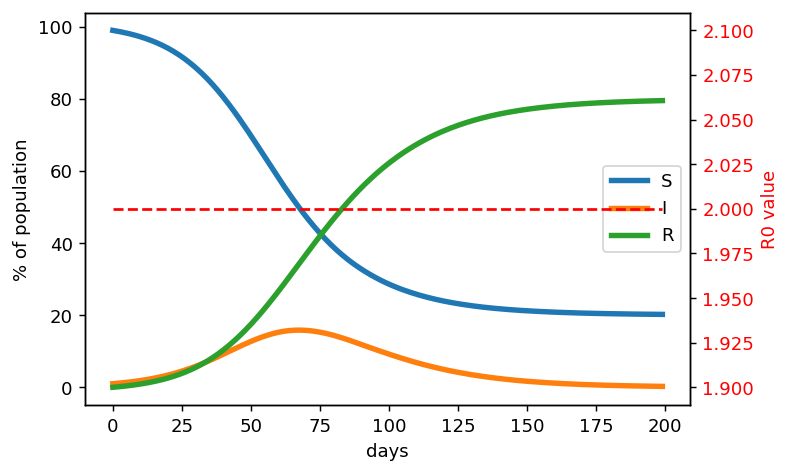

In [9]:
integrate_sir(constant_r0)

### In practice

Proposed by [5]

\begin{align*}
\dot{S}_k = &-\beta I_k S_k &- \sum_l^{n_c} \tilde{\beta}_{kl} S_k I_l \\ 
\dot{I}_k = &+\beta I_k S_k &+ \sum_l^{n_c} \tilde{\beta}_{kl} S_k I_l &- \frac{\gamma_1}{\omega - 1} I_k &- \gamma_1 I_k \\ 
\dot{Q}_k = &&&+ \frac{\gamma_1}{\omega - 1} I_k  &&- \gamma_2Q_k &- \gamma_2 \frac{\mu \omega}{1 - \mu \omega} Q_k \\
\dot{R}_k = &&&&+ \gamma_1 I &+ \gamma_2 Q_k \\
\dot{D}_k = &&&&&&+ \gamma_2 \frac{\mu \omega}{1 - \mu \omega} Q_k 
\end{align*}

With $\tilde{\beta}_{kl} = \beta_{CC}\sqrt{\beta_k \beta_l} \frac{N^\xi_k N^\lambda_l }{N^{\xi + \lambda}_max} e^{-\frac{r_{kl}}{r}}$

### Influence of the cutoff value

Choosing a cutoff value is not trivial.

![](../sparsity_vs_mse.png)

#### Information about the countries

List of country indicators relevant to the pandemic by the World Bank [2], divided into 3 categories:

- Health: general information about health infrastructure, economics and mortality causes.
- Water & Sanitation: information about hygiene.
- Age & Population: demographic indicators.




#### Information about the government measures

Social distancing measures had a huge impact on the development of the disease and we want to take them into account. We use a "Stringency Index" provided by a group of researchers from Oxford [3].
- An aggregation of policy indicators: information on containment and closure policies, such as school closures and restrictions in movement.
- Should not be interpreted as effectiveness of the measures.


In [14]:
def plot_cases_and_stringency(country):
    country_data = ds.cumulative(country)

    fig, ax1 = plt.subplots(dpi=80)

    color = 'tab:red'
    ax1.set_xlabel('time')
    ax1.set_ylabel('Cases')
    ax1.plot(country_data[:-1], 'k.', label='cases')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()

    color = 'tab:blue'
    ax2.set_ylabel('Stringency', color=color)
    ax2.plot(ds.stringency(country)[:-1], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title(country)
    plt.show()
    
widgets.interact(plot_cases_and_stringency, country=ds.all_ox_countries()[1:]);

interactive(children=(Dropdown(description='country', options=('Aruba', 'Afghanistan', 'Angola', 'Anguilla', '…

### Fitting

Experimental setting:

- 4857 training examples (rows in the $X$ and $X_2$ matrices) and 1028 test examples for 105 and 26 countries respectively. 
- 42 variables (state + stringency + indicators). 
- Polynomial terms with a maximum degree of 3.
- We neglect the terms that are constant with respect to the state.
- This yields more than 800 polynomial terms. 

The number of polynomial terms is equal to $\frac{(n + r - 1)!}{ r! (n - 1)! }$ where $n$ is the number of variables and $r$ the maximum degree.



### Putting it all together

Here is a description of the information that was used for the model:

| Variable  | Explanation  | Nature  |
|---|---|---|
| $x_t$  | The state of the system: the number of cases in the country  | The state, time-dependent  |
| $i_{1, t}$  |  Stringency index: how severe are the containment measures. (the control) | Time-dependent  |
| $i_{2}$ | Human development index  | Constant  |
| $i_{3}$ | Total population  | Constant  |
| $i_{4}$ | Population ages 65 and above (% of total)  | Constant  |
| $i_{5}$ | Hospital beds (per 1,000 people)  |  Constant |
| ... | ...  | ...  |
| $i_{40}$ | Cause of death, by injury (% of total)  | Constant  |



We want to find a general formula of the following form<small><sup>1</sup></small>:

$$x_{t+1} = f(x_t, i_{1, t}, i_2, i_3, i_4, ... , i_{40})$$ 

-----
<small><sup>1</sup>The country indexes were omitted for better readability.</small>

### Study of the influence of the delay

It is obvious that the influence of the delay in the dynamics of the pandemic is very important [8]. But we couldn't find any delay that would give significantly better results than no delay.

<center><img src='delay_study.png' width="700"/></center>

### Indicators

```
Hospital beds (per 1,000 people),
Physicians (per 1,000 people),
Nurses and midwives (per 1,000 people),
UHC service coverage index,
Human development index,
Current health expenditure (% of GDP),
Current health expenditure per capita (current US$),
Current health expenditure per capita, PPP (current international $),
Out-of-pocket expenditure (% of current health expenditure),
Out-of-pocket expenditure per capita (current US$),
Out-of-pocket expenditure per capita, PPP (current international $),
Diabetes prevalence (% of population ages 20 to 79),
Life expectancy at birth, female (years),
Life expectancy at birth, total (years),
Life expectancy at birth, male (years),
Mortality rate, adult, female (per 1,000 female adults),
Mortality rate, adult, male (per 1,000 male adults),
Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%),
Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70, female (%),
Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70, male (%),
Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total),
Cause of death, by injury (% of total),
Cause of death, by non-communicable diseases (% of total),
People using at least basic drinking water services (% of population),
People using at least basic sanitation services (% of population),
Population ages 80 and above, female (% of female population),
Population ages 80 and above, male (% of male population),
Population ages 65 and above, female (% of total),
Population ages 65 and above, male (% of total),
Population ages 65 and above (% of total),
Population ages 0-14, female (% of female population),
Population ages 0-14, male (% of male population),
Population ages 0-14 (% of total population),
Population ages 15-64, female (% of female population),
Population ages 15-64, male (% of male population),
Population ages 15-64 (% of total population),
Total population
```

### Importance of the indicators

Let the importance of a variable be the normalized sum of the absolute value of the coefficients of the polynomial terms where this variable appears.



#### For a cutoff value of $10^{-4}$ and sparsity of $0$%

<img src='importances_train.png' width='700'></img>

<!-- ![](importances_train.png) -->

#### For a cutoff value of $1$ and sparsity of $98$%

![](importances_test.png)

### Logistic trajectories

Most of the trajectories have an evolution close to a logistic function:

$$x(t) = \frac{a}{1+e^{-b(t-c)}}$$

Where $a, b$ and $c$ are the parameters.

Since the derivative of a logistic function is: $\frac{dx}{dt}(t) = x(t)\times (1 - x(t))$ we should be able to have some baseline results with polynomials of a maximum degree of 2.




### Integrating the identified system

We can easily generate a trajectory with $\: x_{k+1} = \theta(x_k)\xi \:$ or using the differential formulation $\: \dot{x} = \theta(x)\xi \:$ and solving the ODE. But synchronizing is difficult.